# Coulomb Potential
One interesting prospect of performing grid-based simulations on quantum computers is that we can model wavepackets interacting via the Coulomb potential with good scaling. You may choose to do that by:
- Modelling a particle e.g. nucleus simply as a classical Coulomb field. 
- Modelling two wavepackets in two particle registers interacting via a Coulomb potential

In [1]:
import pyquest
pyquest.env

QuESTEnvironment(gpu_accelerated=False, multithreaded=True, distributed=False, num_threads=12, rank=0, num_ranks=1, precision=2)

In [2]:
import numpy as np
from qarsen_lite.singleparticlefunctions import gwp_1D, harmonic_osc_1D
import matplotlib.pyplot as plt

We will start with two Gaussian particles inside a 1D potential interacting via the repulsive Coulomb potential.

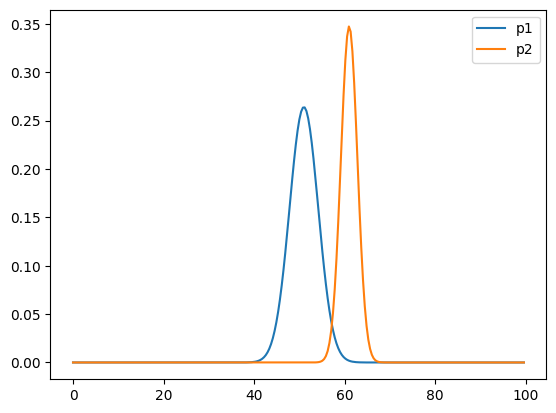

In [3]:
# define spatial grid
L = 100 # box size 
n_qubits = 8 # per spatial dimension!

dx = L/(2**n_qubits)
x_grid = np.array([dx*n for n in range(int(2**n_qubits))])

# define wavefunction in 1D
psi_x1 = gwp_1D(x_grid, xc=51, pc=0, alpha=0.05, gamma=0)* np.sqrt(dx)
psi_x2 = gwp_1D(x_grid, xc=61, pc=0, alpha=0.15, gamma=0)* np.sqrt(dx)

plt.plot(x_grid, abs(psi_x1), label="p1")
plt.plot(x_grid, abs(psi_x2), label="p2")
plt.legend()

In [4]:
sum(abs(np.tensordot(psi_x2, psi_x1, axes=0).flatten())**2)

0.9999999999999964

## Loading into register

In [5]:
from pyquest import Register

reg_init = Register(n_qubits + n_qubits) # 2x5 qubits!
reg_init[:] = np.tensordot(psi_x2, psi_x1, axes=0).flatten()

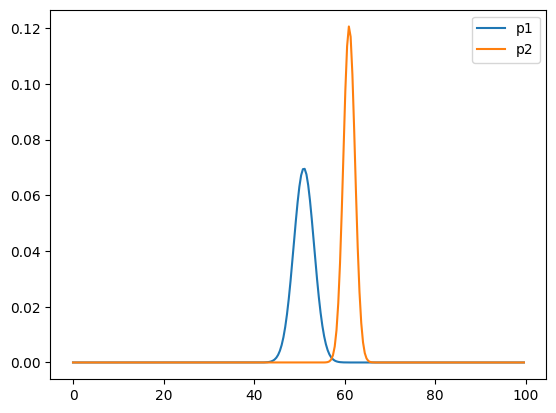

In [6]:
p1_qubit_ids = list(range(0, n_qubits))
p1_density = reg_init.prob_of_all_outcomes(p1_qubit_ids)
plt.plot(x_grid, p1_density, label="p1")

p2_qubit_ids = list(range(n_qubits, 2*n_qubits))
p2_density = reg_init.prob_of_all_outcomes(p2_qubit_ids)
plt.plot(x_grid, p2_density, label="p2")

plt.legend()

## Time evolution

In [7]:
from qarsen_lite.unitaries import gen_QFT_circ, gen_Quadratic_PhaseFunc, gen_pairwise_Coulomb_PhaseFunc

def gen_propagators(n_qubits, dx, xc, dt, m, k):
    """
    Specific for 2 particles in 1D harmonic potential, second order trotter - edit as necessary to generalise
    """
    # qubit targets
    init_qbit_idx = 0
    targets = []
    for _ in range(2):
        targets.append(list(range(init_qbit_idx, init_qbit_idx+n_qubits)))
        init_qbit_idx += n_qubits
    
    # QFT circuits
    cQFT_circs = [gen_QFT_circ(targets[d][0], targets[d][-1]) for d in range(2)]
    icQFT_circs = [circ.inverse for circ in cQFT_circs]
    # Kinetic propagator
    dp = 2*np.pi/(2**n_qubits * dx)
    pc = 2**n_qubits * dp / 2 # calculate the centre of the momentum space
    coeff = -dt/(2*m)
    K_props = [gen_Quadratic_PhaseFunc(targets[d], dp, 0.5*coeff, pc) for d in range(2)]

    # Potential 
    # - external harmonic potential
    coeff = -k*dt/2
    V_props = [gen_Quadratic_PhaseFunc(targets[d], dx, coeff, xc) for d in range(2)]
    # - pairwise interaction potential
    Z = 5
    coeff = Z*dt
    V_props.append(gen_pairwise_Coulomb_PhaseFunc(targets, coeff, dx))
    

    return targets, cQFT_circs, icQFT_circs, K_props, V_props

In [8]:
def apply_single_step(reg, qft_circs, iqft_circs, K_props, V_props):
    """
    """
    for qft in qft_circs:
        reg.apply_circuit(qft)
    for k in K_props:
        reg.apply_operator(k)
    for iqft in reversed(iqft_circs):
        reg.apply_circuit(iqft)
    
    for v in V_props:
        reg.apply_operator(v)

    for qft in qft_circs:
        reg.apply_circuit(qft)
    for k in K_props:
        reg.apply_operator(k)
    for iqft in reversed(iqft_circs):
        reg.apply_circuit(iqft)

In [9]:
from tqdm import tqdm

def U_RTE(reg_init, n_qubits, dx, t_tot, n_steps, xc, m, k, sample_every=10):
    """
    """
    dt = t_tot/n_steps # time resolution
    reg = Register(copy_reg=reg_init) # copy initial register
    targets, Qft, iQft, K, V = gen_propagators(n_qubits, dx, xc, dt, m, k) # generate propagators

    autocorrelation = []
    particle_densities = [[], []]
    print("Running SO-QFT propagation...")
    for n in tqdm(range(n_steps)):
        apply_single_step(reg, Qft, iQft, K, V)

        # saving data
        if n%sample_every==0:
            autocorrelation.append(reg*reg_init)
            for i, t_reg in enumerate(targets):
                particle_densities[i].append(reg.prob_of_all_outcomes(t_reg))
    print("Done!")

    return autocorrelation, particle_densities

In [ ]:
t_tot = 100
n_steps = 10000
sample_every= 100
t_grid = np.linspace(0, t_tot, int(n_steps/sample_every))

k = 0.01

auto, particles = U_RTE(
    reg_init, 
    n_qubits, 
    dx, 
    t_tot=t_tot, 
    n_steps=n_steps, 
    xc=L/2, 
    m=1, 
    k=k, 
    sample_every=sample_every)

Running SO-QFT propagation...


In [ ]:
len(particles[0])

In [ ]:
from qarsen_lite.animation import animate_1D_dynamics

anim = animate_1D_dynamics(x_grid=x_grid,
                            dyn=particles,
                            t_grid=np.round(t_grid),
                            V_array=np.array([k/2*(x-L/2)**2 for x in x_grid]),
                            psi_ylim=(-0.01, 0.18),
                            V_ylim=(0, 3.0)
                            )

In [ ]:
from IPython.display import HTML

import matplotlib.animation as animation

writergif = animation.PillowWriter(fps=5)
anim.save('anim_interacting.gif', writer=writergif)

In [ ]:
plt.plot(t_grid, np.real(auto))
plt.plot(t_grid, np.imag(auto))
plt.plot(t_grid, np.abs(auto))
plt.xlabel("t")